In [1]:
# !pip install hurst
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import time
import warnings
from hurst import compute_Hc
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# import torch.nn as nn
# import torch
# from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

In [ ]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''

In [2]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [3]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')
train.head(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [7]:
# dataframe dimensiosn
print(train.shape)

def pl_replace(df, replace_dict):
    return df.with_columns(pl.all().replace(replace_dict))

# For eeg data
def loadeeg(path):
    eeg = pl.read_parquet(path)
    # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    eeg = eeg.fill_null(0)
    eeg = eeg.fill_nan(0)
    return (eeg)

# For spectrograms
def loadspect(GET_ROW):
    
    row = train.iloc[GET_ROW]
#     Needs to be changed to match the eeg function
    spectrogram = pl.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
    spec_offset = int( row.spectrogram_label_offset_seconds )
    spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                         &(spectrogram.time<spec_offset+600)]
    time = (np.linspace(0,600,spectrogram.shape[0])) - 25

    return (row,spectrogram,time)


(106800, 15)


# Compute time domain features

In [8]:
# Initialise a few things
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
start = np.argmin(np.abs(time_eeg+5))
stop = np.argmin(np.abs(time_eeg-5))

train_grby = train.groupby("eeg_id")

(18000, 20)


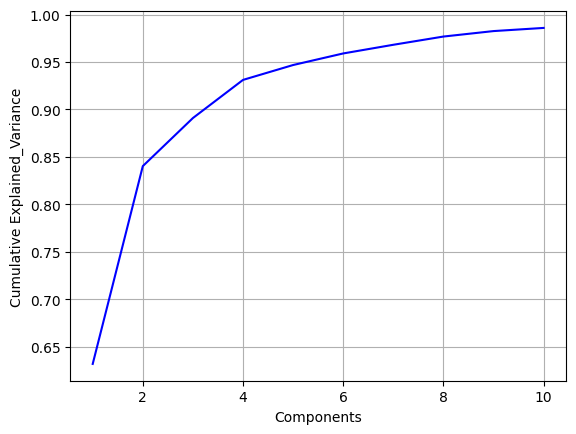

In [9]:
i = 0

path = f'{EEG_PATH}{1628180742}.parquet'
fulleeg = loadeeg(path)
print(fulleeg.shape)

n = 10
pca = PCA(n)
pcafit = pca.fit_transform(fulleeg)

pca.explained_variance_ratio_
ev = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,n+1),ev, "b-")
plt.xlabel('Components')
plt.ylabel('Cumulative Explained_Variance')
plt.grid()
plt.show()
plt.close()

# selection 8 components for ~97.5% of the explained variance

In [10]:
def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out

In [49]:
channels_id = pd.Series(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
segment_names = {-1:"_before",0:"_during",1:"_after"}
var = ['eeg_label_offset_seconds']

n_comp = 10
PCA_columns = pd.Series(range(0,n_comp)).apply(lambda x: 'pca' + str(x)).to_list()

# I add the names of the columns here to not calculate it within the for loop. 
colnames = ['pca0_mean', 'pca0_std', 'pca0_kurt', 'pca0_skew', 'pca0_rng', 'pca0_linelength', 'pca0_rms', 'pca0_hurst', 'pca1_mean', 'pca1_std',
            'pca1_kurt', 'pca1_skew', 'pca1_rng', 'pca1_linelength', 'pca1_rms', 'pca1_hurst', 'pca2_mean', 'pca2_std', 'pca2_kurt', 'pca2_skew',
            'pca2_rng', 'pca2_linelength', 'pca2_rms', 'pca2_hurst', 'pca3_mean', 'pca3_std', 'pca3_kurt', 'pca3_skew', 'pca3_rng', 'pca3_linelength',
            'pca3_rms', 'pca3_hurst', 'pca4_mean', 'pca4_std', 'pca4_kurt', 'pca4_skew', 'pca4_rng', 'pca4_linelength', 'pca4_rms', 'pca4_hurst',
            'pca5_mean', 'pca5_std', 'pca5_kurt', 'pca5_skew', 'pca5_rng', 'pca5_linelength', 'pca5_rms', 'pca5_hurst', 'pca6_mean', 'pca6_std',
            'pca6_kurt', 'pca6_skew', 'pca6_rng', 'pca6_linelength', 'pca6_rms', 'pca6_hurst', 'pca7_mean', 'pca7_std', 'pca7_kurt', 'pca7_skew',
            'pca7_rng', 'pca7_linelength', 'pca7_rms', 'pca7_hurst', 'pca8_mean', 'pca8_std', 'pca8_kurt', 'pca8_skew', 'pca8_rng', 'pca8_linelength',
            'pca8_rms', 'pca8_hurst', 'pca9_mean', 'pca9_std', 'pca9_kurt', 'pca9_skew', 'pca9_rng', 'pca9_linelength', 'pca9_rms', 'pca9_hurst', 'segments']


n_parquet = 170 # 0:173 is ~1% of the dataset
mask = train.eeg_id.isin(train.eeg_id.unique()[0:n_parquet])
TD_Features_wf = train.loc[mask, ['eeg_id']].copy()
TD_Features_lf = pl.DataFrame()

# polars functions with columns, and makes it harder to replace values of a single row. It requires to always change the entire column, 
# and the python code to do so is heavy. To avoid it, I have created a predefined numpy array called "segment_col" with the values of 
# the "segments" column (-1,0,1). For each eeg dataset, I will simply add a new column containing all the predefined numpy values. 
segment_col = np.zeros(len(time_eeg))
mask = time_eeg < -5
segment_col[mask] = -1
mask = time_eeg > 5
segment_col[mask] = 1

t = time.time()

# Loop over each row of the train set
for count, id in enumerate(train.eeg_id.unique()[0:n_parquet]):
    if count%10 == 0: print(count)
    
    path = f'{EEG_PATH}{id}.parquet'
    fulleeg = loadeeg(path)
    pca = PCA(n)
    pcaeeg = pl.DataFrame(pca.fit_transform(fulleeg))
    pcaeeg.columns = PCA_columns
    pcaeeg = pcaeeg.with_row_count(offset = 0)

    for i, offset in train_grby.get_group(id)[var].itertuples():

        eeg = pcaeeg.filter((pl.col("row_nr") >= offset*200) & (pl.col("row_nr") <= (offset+50)*200)).clone()
        eeg = eeg.with_columns(pl.Series("segments", segment_col[0:eeg.shape[0]]))
        eeg_by_seg = eeg.groupby('segments')

        features = eeg_by_seg.agg(pl.exclude("row_nr").mean().name.suffix("_mean"),
                          pl.exclude("row_nr").std().name.suffix("_std"),
                          pl.exclude("row_nr").kurtosis().name.suffix("_kurt"),
                          pl.exclude("row_nr").skew().name.suffix("_skew"),
                          (pl.exclude("row_nr").max()-pl.exclude("row_nr").min()).name.suffix("_rng"),
                          pl.exclude("row_nr").diff().abs().sum().name.suffix("_linelength"),
                          pl.exclude("row_nr").pow(2).mean().pow(0.5).name.suffix("_rms"),
                          pl.exclude("row_nr").apply(lambda x: hurst_fct(x)).name.suffix("_hurst"))

        
        TD_Features_lf = pl.concat([TD_Features_lf, features])


TD_Features_wf = pl.DataFrame()

for i in [-1,0,1]:
    colnames = pl.Series(TD_Features_lf.columns) + segment_names[i]
    copyTDF_lf = TD_Features_lf.clone().filter(pl.col('segments') == i)
    copyTDF_lf.columns = colnames
    TD_Features_wf = pl.concat([TD_Features_wf, copyTDF_lf], how = "horizontal")

TD_Features_wf = TD_Features_wf.drop(["segments_before", "segments_during", "segments_after"])

print(f"Running time: {time.time()-t} s")


# Note 1: the version with pandas runs 173 parquet files (1% of all) and 1726 rows (1.6% of all) in 1730.8s


# Note 2: filling the wide format dataframe outside of the loop saves 1.8 s per 17 parquet files and/or per 200 lines.

# Note 3: I encountered an error between trials 60 and 70 for the compute_Hc function, hence the use of hurst_fct.
#        The error message is: invalid value encountered in double_scalars

# Note 4: this version with polars runs 173 parquet files (1% of all) and 1721 rows (1.6% of all) in 1322.3s
#         This means that for all parquet files, it should take approximately 22h45. It's a considerable improvement compared to the initial 400+ hours,
#         and compared to the pandas ~29h45 version. 
#         There are ~2640 parquet files in the hidden test data: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/471287
#         It means that the computation time for the test set should probably be between 1h10 (considering the time per row and assuming ~16300 rows 
#         in the test set) and 5h35 (considering the time per parquet file). Let's keep in mind that this is only with time domain features. 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
Running time: 1322.284034729004 s


In [ ]:
# SVD Entropy
# eeg_z = (eeg_seg-eeg_seg.mean())/eeg_seg.std()
#u, s, v = np.linalg.svd(eeg_z, full_matrices=True)
# s = s/np.sum(s)
#TD_Features.loc[i, channels+"_SVDEn_"+ segment_names[seg]] = -(s*np.log(s)).sum()
# linelength['SVDEn' + seg] = SVDEn

# # Entropy
# add = eeg.sum()
# eegnorm = eeg/add
# entropy = -(eegnorm*np.log(eegnorm)).sum() # There may be problems here with the log.
# entropy.index = entropy.index + '_entropy' + seg
# entropy = entropy.to_frame().transpose()

# Hurst Exponent
# hurst = []
#for idx,channel in enumerate(eeg.keys()):
#    h, c, data = compute_Hc(eeg[channel], simplified=True)
#    hurst.append(h)
# hurst = pd.DataFrame([np.array(hurst).reshape(-1)], columns=(eeg.keys()+ 'hurst' + seg))

In [48]:
print(TD_Features_lf.shape)
print(TD_Features_wf.shape)

(201, 81)
(67, 240)


In [31]:
TD_Features_lf.tail(20)

segments,pca0_mean,pca1_mean,pca2_mean,pca3_mean,pca4_mean,pca5_mean,pca6_mean,pca7_mean,pca8_mean,pca9_mean,pca0_std,pca1_std,pca2_std,pca3_std,pca4_std,pca5_std,pca6_std,pca7_std,pca8_std,pca9_std,pca0_kurt,pca1_kurt,pca2_kurt,pca3_kurt,pca4_kurt,pca5_kurt,pca6_kurt,pca7_kurt,pca8_kurt,pca9_kurt,pca0_skew,pca1_skew,pca2_skew,pca3_skew,pca4_skew,pca5_skew,…,pca3_rng,pca4_rng,pca5_rng,pca6_rng,pca7_rng,pca8_rng,pca9_rng,pca0_linelength,pca1_linelength,pca2_linelength,pca3_linelength,pca4_linelength,pca5_linelength,pca6_linelength,pca7_linelength,pca8_linelength,pca9_linelength,pca0_rms,pca1_rms,pca2_rms,pca3_rms,pca4_rms,pca5_rms,pca6_rms,pca7_rms,pca8_rms,pca9_rms,pca0_hurst,pca1_hurst,pca2_hurst,pca3_hurst,pca4_hurst,pca5_hurst,pca6_hurst,pca7_hurst,pca8_hurst,pca9_hurst
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1.0,3.989649,2.969036,2.341632,0.594898,-0.493934,-0.603898,0.460857,-0.769646,-0.490971,-0.166365,783.19007,65.194552,41.111255,27.308815,10.95537,10.825976,8.950014,5.593853,5.606909,4.464233,-1.486744,0.442123,-0.207997,-0.263138,-0.497272,0.002349,-0.044223,-0.080386,-0.208677,0.286609,0.001266,-0.17908,0.335321,-0.137532,-0.143695,-0.06563,…,149.282477,60.353904,72.068808,52.688875,36.640087,32.167461,29.539922,4.5585e6,21068.478715,20461.380461,7511.199885,6192.097499,14484.457463,4438.012752,6507.401065,3536.693094,8894.83759,783.102353,65.253984,41.172759,27.311882,10.965132,10.841455,8.960755,5.64586,5.627666,4.466774,0.048359,0.401537,0.387295,0.372296,0.348433,0.339985,0.363589,0.314762,0.34152,0.284629
1.0,0.802891,7.39486,1.930869,-0.95776,-0.162198,1.16004,-0.260976,1.064436,-0.27325,-1.037975,784.125553,57.682942,45.215149,29.065406,12.73705,9.164033,8.689387,6.316913,5.118767,4.750272,-1.488801,0.191628,-0.024142,-0.061093,-0.416788,-0.337059,1.034279,-0.541686,0.230915,-0.294074,-0.000298,0.443466,0.070515,-0.250414,0.16581,0.165645,…,152.849839,70.654123,59.018705,67.954823,32.25383,33.40185,27.535441,4.5160e6,21024.944292,20753.503034,7849.039777,6266.309025,14554.080908,4501.852673,6635.620122,3596.725263,9015.771808,784.027942,58.147862,45.250711,29.07755,12.736491,9.236027,8.692219,6.405189,5.125416,4.861773,0.027722,0.396775,0.403221,0.3612,0.388405,0.304703,0.398118,0.316085,0.334525,0.283463
0.0,-3.976619,4.241564,5.134108,1.822452,1.888653,0.86407,-0.433347,0.560592,-0.126235,-0.238812,780.488976,58.289875,48.869828,27.718167,11.693129,10.188019,6.860467,6.570545,6.244866,5.323341,-1.490622,0.995175,-0.473592,0.608797,-0.56176,0.511839,0.08863,-0.101829,0.020221,-0.30791,-0.000586,0.096079,0.425783,-0.528886,-0.372803,0.320999,…,167.9,58.872253,69.171621,36.971216,37.360574,36.194608,32.398449,2.2247e6,10332.471458,10303.840127,3748.067379,3070.352613,7241.623246,2168.929998,3246.096523,1758.849629,4500.097506,780.303962,58.429458,49.126622,27.771099,11.841786,10.222057,6.872427,6.592779,6.244581,5.327365,0.025835,0.495337,0.437127,0.441461,0.392279,0.397711,0.373894,0.390817,0.409186,0.337729
-1.0,2.763735,1.054575,-1.340449,0.024042,-0.347905,-0.724455,0.314196,-0.89447,0.009805,0.085313,782.141292,55.422557,41.283031,26.78769,11.291868,10.434224,8.703804,5.815513,5.767866,4.550257,-1.486759,-0.189133,-0.083585,-0.322036,-0.503601,0.297096,-0.114679,-0.325893,-0.388838,0.060582,0.001086,0.018247,0.233433,-0.15398,-0.145703,-0.031753,…,149.282477,63.120038,72.068808,52.688875,35.17917,33.176964,29.539922,4.5580e6,20770.133761,20413.105546,7541.508169,6155.582785,14482.924226,4443.975879,6475.060942,3495.054494,8895.468616,782.048426,55.425664,41.299631,26.784353,11.295816,10.458042,8.708386,5.883181,5.767154,4.550488,0.049856,0.366909,0.391252,0.362161,0.357603,0.346173,0.366956,0.320684,0.340137,0.285257
1.0,0.560157,2.929142,-0.685222,-

In [ ]:
staticX2 = np.fft.fft(eeg['Fp1'])

staticHz = np.linspace(0,100,int(len(eeg['Fp1'])/2+1))

plt.plot(staticHz[1:],np.abs(staticX2[1:len(staticHz)]),'-.',label='FFT')
plt.show()

In [ ]:
# Explore what frequencies are in the spectrogram

allkeys = spectrogram.keys()
llkeys = []
for key in allkeys:
    if 'LL' in key:
        llkeys.append(key)
        
print(llkeys)

In [ ]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(eeg['Fp1'].to_numpy(),fs = 200,noverlap=10)
plt.pcolormesh(t,f,Sxx,shading='gouraud',vmin=0,vmax=10)
plt.ylabel('Frequency (a.u.)')
plt.xlabel('Time (a.u.)')
# plt.ylim([0,.005])
plt.show()


In [ ]:
spect = spectrogram.to_numpy()
plt.imshow(spect,vmin= 0, vmax = 10)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(fulleeg)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])